# Runtime: approx. 80 minutes

In [227]:
from pylab import *
import matplotlib.pyplot as plt
import batman
from scipy.special import erfcinv
from scipy.special import hyp2f1
from scipy.interpolate import CubicSpline
import copy
import corner

In [228]:
Grv = 6.67408e-11                    # gravitational constant [m^3 kg^-1 s^-2]

# Values from Jenkins literature

per_lit = 384.843             # orbital period [days]
tau_lit = 54833 + 314.98      # transit midpoint epoch [BJD - 2400000]
p_lit =  0.0128               # scaled planet radius Rp/R*          
b_lit = 0.69                  # impact parameter b 
inc_lit = 89.806              # inclination [deg]
T_lit = 10.63 / 24.           # transit duration [days]
logrho_lit = 3.03

In [229]:
# Other properities
#rhostar = np.power(10.0, params[0])
#a_rs = np.power( ( Grv*(params[1]*86400.0)**2*rhostar )/( 3.*pi ), (1/3) ) # a/Rstar

# 1) Import the data & Plot it

In [230]:
data = np.genfromtxt("lightcurve.dat", dtype=None)

time = data[:,0]      # times of observations
flux = data[:,1]      # relative fluxes
flux_err = data[:,2]   # errors on fluxes

time_folded = np.empty([len(time)])

for i in range(len(time)):
    time_folded[i] = time[i]-tau_lit-per_lit*np.round((time[i]-tau_lit)/per_lit)
    
# sort the data by increasing time
d = np.hstack((time_folded.reshape((len(time),1)), flux.reshape((len(flux),1)), flux_err.reshape((len(flux),1))))
d = d[d[:, 0].argsort()]

time_folded = d[:, 0]
flux = d[:, 1]
flux_err = d[:, 2]

In [231]:
# Set a definition for the model
def model(times, theta):
     
    p = theta[0]   # scaled planet radius 
    b = theta[1]
    
    # Initialize the Batman code
    transit_params = batman.TransitParams()
    
    # Set the model parameters
    transit_params.rp = p                                    # scaled planet radius   
    transit_params.a = b / cos(inc_lit * (pi/180))           # scaled semi-major axis 
    transit_params.inc = inc_lit                             # orbital inclination [degrees]
    transit_params.per = per_lit                             # orbital period [days]
    transit_params.t0 = 0.  # 0 for time folded              # transit midpoint time [days]
    
    # These parameters are just kept fixed
    transit_params.ecc = 0.                     # eccentricity
    transit_params.w = 90.                      # longitude of periastron [degrees]
    transit_params.limb_dark = "quadratic"      # limb darkening model--other choices include quadratic, etc.
    
    # Coefficients for a nonlinear limb darkening law.
    transit_params.u = [0.459196, 0.2248176]
    
    # Call the Batman code
    m = batman.TransitModel(transit_params, times, supersample_factor=30, exp_time=0.020434)
    
    # Calculate the flux
    f = m.light_curve(transit_params) 
    
    return f

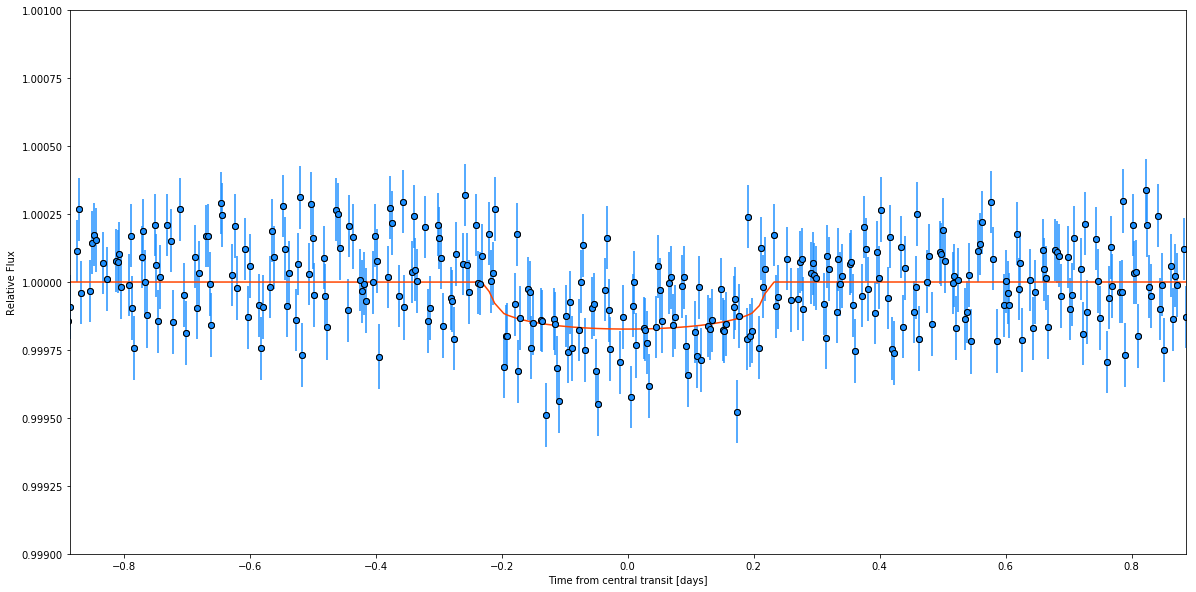

In [232]:
flux_mod = model(time_folded, [p_lit, b_lit])

plt.figure(figsize=(20,10))
plt.plot(time_folded, flux_mod, c='orangered')
plt.plot(time_folded, flux, 'o', markeredgecolor='k', color='dodgerblue')
plt.errorbar(time_folded, flux, yerr=flux_err, c='dodgerblue', fmt='o', mec='k')
plt.xlabel('Time from central transit [days]')
plt.ylabel('Relative Flux')
plt.xlim(-2*T_lit,2*T_lit)
plt.ylim(0.999,1.001)
plt.show()

(0.9985, 1.001)

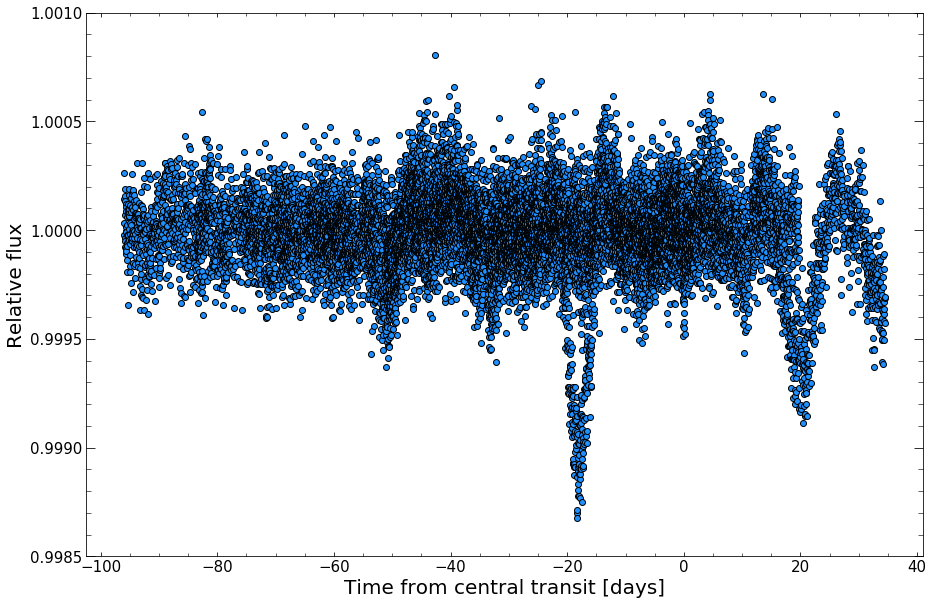

In [233]:
# Plot of all the data

plt.figure(figsize=(15,10))
#plt.errorbar(t_obs_folded, f_obs, yerr=sigf_obs,fmt='ko')
plt.plot(time_folded, flux, 'o', markeredgecolor='k', color='dodgerblue')
plt.minorticks_on()

#plt.xlabel('BJD – 2400000', fontsize = 20)
#plt.xticks(np.linspace(round((t_obs)[0], 1), round((t_obs)[-1],1), 3))
plt.tick_params(axis='x', which='minor', length = 3)
plt.tick_params(axis='x', which='major', length = 4, labelsize=15)
#plt.xlim(-2*T_literature,+2*T_literature)
plt.xlabel('Time from central transit [days]', fontsize=20)

plt.tick_params(axis='y', which='minor', length = 5)
plt.tick_params(axis='y', which='major', length = 9, labelsize=15)
plt.tick_params(which ='both', direction ='in', top=True, right=True)
plt.ylabel('Relative flux', fontsize = 20)

plt.ylim(0.9985,1.001)

#plt.rc('axes.formatter', useoffset=False)
#plt.savefig('labx.pdf')

# 2) Remove outliers & Apply detrending

In [234]:
# Define a moving median function 
def moving_median(t,x,window):
    tsmooth = []
    xsmooth = []
    
    i = 0
    break_next = False
    
    while True:
        
        j = i
        
        # get position of the last element for which within the window
        while ((j < len(t)) and (t[j] <= (t[i] + window))):
            j += 1
        
        # median elements up to this position
        tsmooth.append(np.median(t[i:j]))
        xsmooth.append(np.median(x[i:j]))
        
        if (break_next == True): break
        
        i += 1
        
        if ((t[i] + window) > t[-1]): 
            break_next = True
    
    return (tsmooth, xsmooth)

# Calculate moving medians
smooth_window = 3. * T_lit
time_smooth, flux_smooth = moving_median(time_folded,flux,smooth_window)

# Append the edges of the data
i = 0
tlst = []
flst = []
while (time_folded[i] < time_smooth[0]):
    tlst.append(time_folded[i])
    flst.append(flux[i])
    i += 1
    
for e in tlst[::-1]: time_smooth.insert(0, e)
for e in flst[::-1]: flux_smooth.insert(0, e)
    
i = -1
tlst = []
flst = []
while (time_folded[i] > time_smooth[-1]):
    tlst.append(time_folded[i])
    flst.append(flux[i])
    i -= 1
    
for e in tlst[::-1]: time_smooth.append(e)
for e in flst[::-1]: flux_smooth.append(e)

# Take interpolation of the smoothed data
smooth_func = CubicSpline(time_smooth, flux_smooth)

smooth_data = smooth_func(time_folded)

# Split data into good vs bad
sigmas = erfcinv(1/len(flux))*sqrt(2)   # assuming normally distributed data
data2 = []
bad_data = []

for j in range(len(flux)):  
    if ((np.absolute((flux[j] - smooth_data[j]) / flux_err[j]) > sigmas)): 
        bad_data.append([time_folded[j], flux[j], flux_err[j]])
        #print((np.absolute((flux[j] - flux_pred[j]) / flux_err[j])))
    else: data2.append([time_folded[j], flux[j], flux_err[j]])

data2 = np.asarray(data2)
bad_data = np.asarray(bad_data)

1.6142735768903993 % of the original data is an outlier


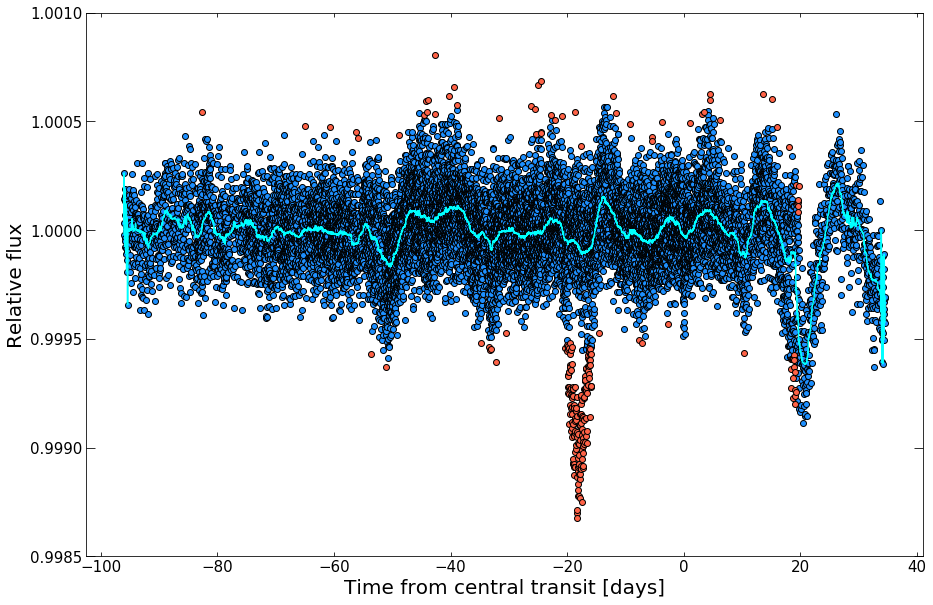

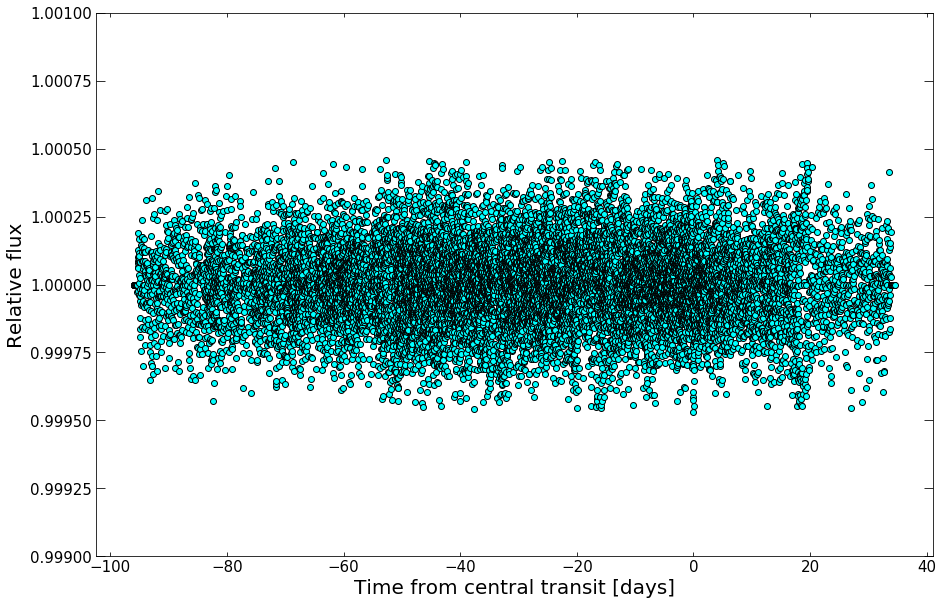

In [235]:
plt.figure(figsize=(15,10))
plt.scatter(data2[:, 0], data2[:, 1], color='dodgerblue', edgecolors='k')
plt.scatter(bad_data[:, 0], bad_data[:, 1],  color='tomato', edgecolors='k')
plt.plot(time_folded, smooth_data, color='cyan')

plt.xlabel('Time from central transit [days]', fontsize = 20)
plt.tick_params(axis='x', which='minor', length = 3)
plt.tick_params(axis='x', which='major', length = 4, labelsize=15)

plt.ylabel('Relative flux', fontsize = 20)
plt.tick_params(axis='y', which='minor', length = 5)
plt.tick_params(axis='y', which='major', length = 9, labelsize=15)
plt.tick_params(which ='both', direction ='in', top=True, right=True)
#plt.xlim(-.9,.9)
plt.ylim(0.9985,1.001)

#plt.plot(np.sort(time_folded), flux_mod, c='r')
#plt.rc('axes.formatter', useoffset=False)
#plt.savefig('labx.pdf')
plt.show

plt.figure(figsize=(15,10))
plt.scatter(data2[:, 0], data2[:, 1] / smooth_func(data2[:, 0]), color='cyan', edgecolors='k')

plt.xlabel('Time from central transit [days]', fontsize = 20)
plt.tick_params(axis='x', which='minor', length = 3)
plt.tick_params(axis='x', which='major', length = 4, labelsize=15)

plt.ylabel('Relative flux', fontsize = 20)
plt.tick_params(axis='y', which='minor', length = 5)
plt.tick_params(axis='y', which='major', length = 9, labelsize=15)
plt.tick_params(which ='both', direction ='in', top=True, right=True)
#plt.xlim(-.9,.9)
plt.ylim(0.9990,1.001)

#plt.plot(np.sort(time_folded), flux_mod, c='r')
#plt.rc('axes.formatter', useoffset=False)
#plt.savefig('labx.pdf')
plt.show

print(100*len(bad_data)/len(flux), '% of the original data is an outlier')

### Investigate extra noise

In [236]:
# Get the data out of the transit

data3 = copy.copy(data2)
data3[:, 1] = data2[:, 1] / smooth_func(data2[:, 0])

time_out = []
flux_out = []

for t,f,ferr in data3:
    if not (-.5*T_lit < t < .5*T_lit):
        time_out.append(t)
        flux_out.append(f)

In [237]:
bmax = 200 # Maximum bin size to try
binsize = [0 for i in range(1,bmax+1)] # Initialize binsize array
rms = [0 for i in range(1,bmax+1)] # Initialize rms array
rms_theory = [0 for i in range(1,bmax+1)]

for b in range(1,bmax+1):
    # Create a binned time series of the data = "binned"
    imax = np.int(np.floor(len(flux_out)/b)) # Length of the new binned array
    binned = []     
    if (b == 1):
        for i in range(imax): binned.append(flux_out[i])
    else:
        for i in range(imax): 
            binned.append(np.mean(flux_out[b*i+1:(i+1)*b]))
    # Compute the r.m.s. of this binned time series
    rms[b-1] = np.std(binned)
    binsize[b-1] = b
    rms_theory[b-1] = b**(-.5)*(imax/(imax-1))**.5

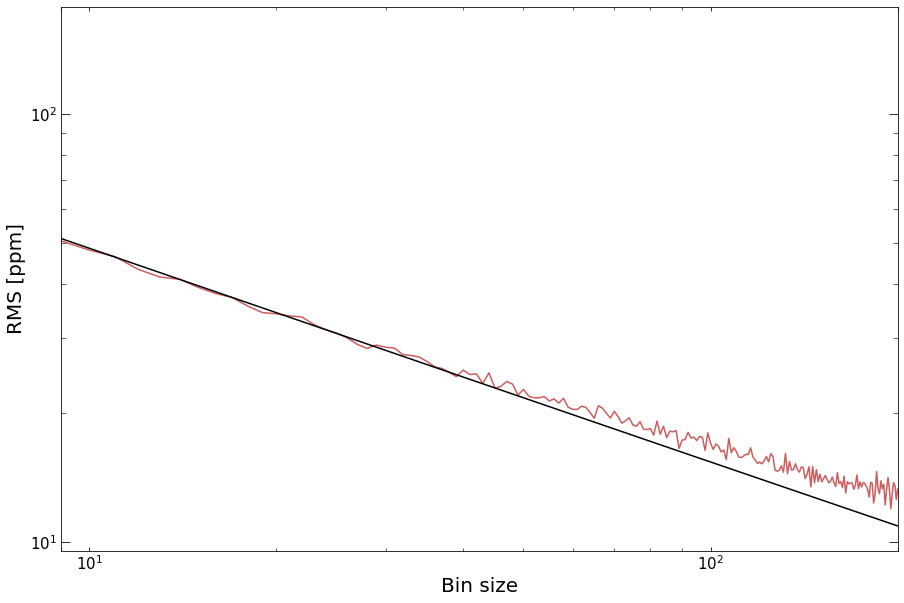

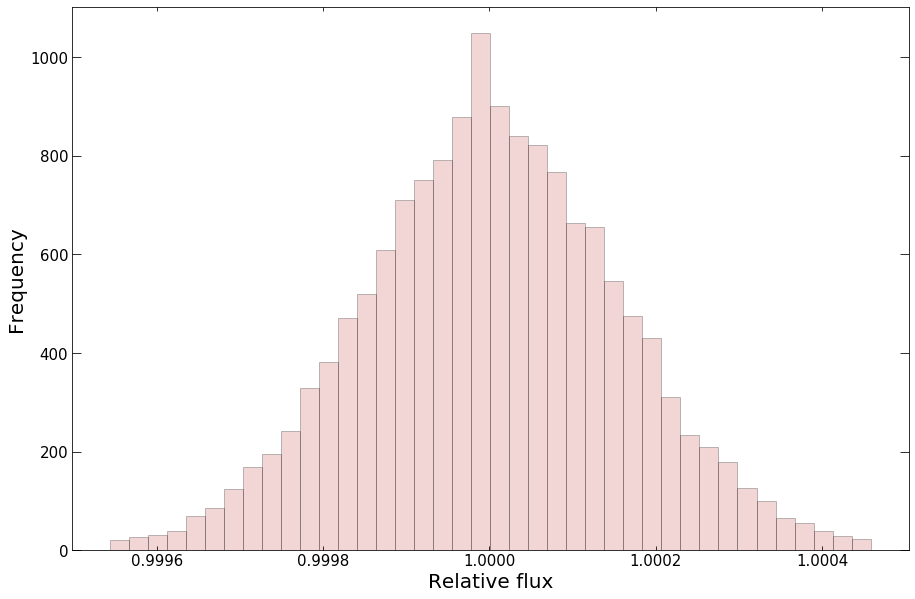

In [238]:
plt.figure(figsize=(15,10))
plt.plot(binsize, array(rms) / 1e-6,color='indianred', markeredgecolor = 'k')
plt.plot(binsize, rms[0]*array(rms_theory) / 1e-6, color='k')
#plt.ylim(np.min(array(rms)), np.max(array(rms)))
plt.xscale('log') 
plt.yscale('log')

plt.xlabel('Bin size', fontsize = 20)
plt.tick_params(axis='x', which='minor', length = 3)
plt.tick_params(axis='x', which='major', length = 4, labelsize=15)

plt.ylabel('RMS [ppm]', fontsize = 20)
plt.tick_params(axis='y', which='minor', length = 5)
plt.tick_params(axis='y', which='major', length = 9, labelsize=15)
plt.tick_params(which ='both', direction ='in', top=True, right=True)
plt.xlim(9, 200)
#plt.ylim(1e-5, .7*1e-4)
#plt.ylim(1, 7)

#plt.rc('axes.formatter', useoffset=False)
#plt.savefig('labx.pdf')
plt.show()

plt.figure(figsize=(15,10))
plt.hist(flux_out, 40, facecolor='indianred', ec='k', alpha=0.25)

plt.xlabel('Relative flux', fontsize = 20)
plt.tick_params(axis='x', which='minor', length = 3)
plt.tick_params(axis='x', which='major', length = 4, labelsize=15)

plt.ylabel('Frequency', fontsize = 20)
plt.tick_params(axis='y', which='minor', length = 5)
plt.tick_params(axis='y', which='major', length = 9, labelsize=15)
plt.tick_params(which ='both', direction ='in', top=True, right=True)
#plt.ylim(1e-6, 3e-5)
#plt.rc('axes.formatter', useoffset=False)
#plt.savefig('labx.pdf')
plt.show()

# 3) Plot a guess model through the cleaned data

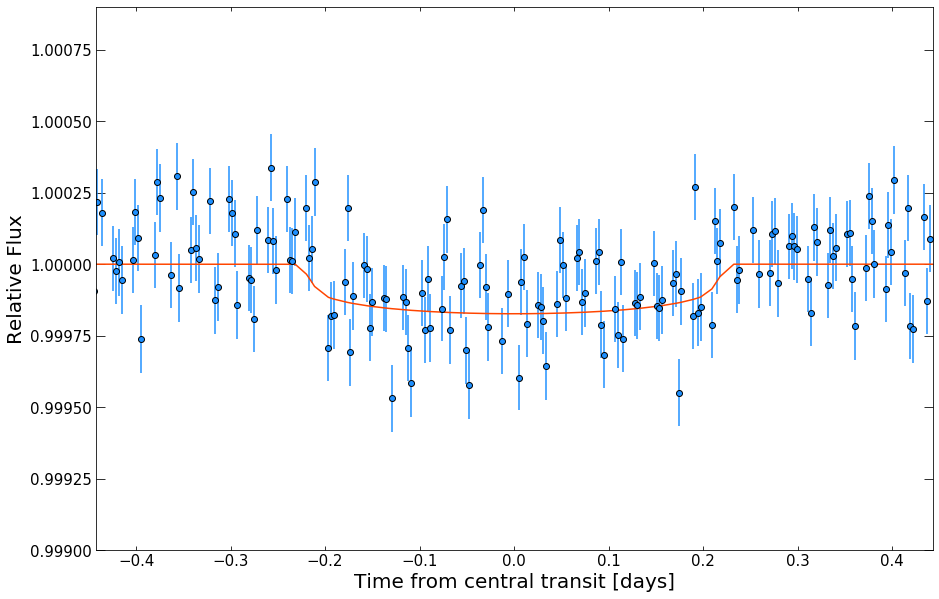

In [239]:
plt.figure(figsize=(15,10))
plt.errorbar(data2[:, 0], data2[:, 1] / smooth_func(data2[:, 0]), yerr=data2[:, 2], 
             c='dodgerblue', fmt='o', mec='k')

plt.xlabel('Time from central transit [days]', fontsize = 20)
plt.tick_params(axis='x', which='minor', length = 3)
plt.tick_params(axis='x', which='major', length = 4, labelsize=15)

plt.ylabel('Relative Flux', fontsize = 20)
plt.tick_params(axis='y', which='minor', length = 5)
plt.tick_params(axis='y', which='major', length = 9, labelsize=15)
plt.tick_params(which ='both', direction ='in', top=True, right=True)
plt.xlim(-1*T_lit, T_lit)
plt.ylim(0.9990,1.0009)

plt.plot(time_folded, flux_mod, c='orangered')
#plt.show()
#plt.rc('axes.formatter', useoffset=False)
#plt.savefig('labx.pdf')

# 4) Run an MCMC fitting for b and Rp/R*

In [240]:
def ln(n): return math.log(n, np.e)

# Set a definition for the loglikelihood, assuming normally distributed data
def log_like(t,f,ferr,theta):
    r = f - model(t, theta) # residuals
    
    chisquared = 0
    for i in range(len(t)): 
        chisquared += ((r[i] / ferr[i])**2)
    
    loglike = (-0.5)*(chisquared + len(f)*ln(2*pi))
    
    for i in range(len(ferr)): 
        loglike -= ln(ferr[i])
        
    return loglike

# Use the cleaned data and focus on the region near the transit
time_folded = data2[12180:12450, 0]
flux = data2[12180:12450, 1] / smooth_func(data2[12180:12450, 0])
flux_err = data2[12180:12450, 2]

In [241]:
theta_shape = [(0., .1), (0., 1.)]

# Set a definition for the logpriors
def log_prior(theta, theta_shape):
    
    p = theta[0]           # ratio-of-radii, Rp/R*
    b = theta[1]           # impact parameter, b 
    
    logpriors = []
    
    p_min, p_max = theta_shape[0]
    b_min, b_max = theta_shape[1]
    
    intrinsic_prior_p = p**-1          # uninformative prior, log-uniform     (normalization later)
    obs_bias_p = p**2.5                # observational bias (from literature) (normalization later)
    
    # overall prior on p 
    prior_p = intrinsic_prior_p * obs_bias_p 
    c_p = 2.5/(p_max**2.5 - p_min**2.5)
    prior_p *= c_p                     # factor in normalization
    
    logpriors.append(ln(prior_p))
    
    intrinsic_prior_b = 1              # uninformative prior, uniform  (normalization later)
    obs_bias_b = (1 - b**2)**.25       # observational bias (good match to observations shown in literature)
    
    # overall prior on b
    prior_b = intrinsic_prior_b * obs_bias_b
    
    # factor in normalization
    c_b = 3/(b_max*(hyp2f1(.5, .75, 1.5, b_max**2) + 2*(1 - b_max**2)**.25) - \
               b_min*(hyp2f1(.5, .75, 1.5, b_min**2) + 2*(1 - b_min**2)**.25))
    prior_b *= c_b
    
    logpriors.append(ln(prior_b))
    
    logprior = np.sum(np.asarray(logpriors))
    
    return logprior

def priorp(p):
    p_min, p_max = theta_shape[0]
    return (p**1.5)*(2.5/(p_max**2.5 - p_min**2.5))

def priorb(b):
    b_min, b_max = theta_shape[1]
    return (1 - b**2)**.25 * (3/(b_max*(hyp2f1(.5, .75, 1.5, b_max**2) + 2*(1 - b_max**2)**.25) - \
               b_min*(hyp2f1(.5, .75, 1.5, b_min**2) + 2*(1 - b_min**2)**.25)))

def draw_random_number_from_prior(prior, interval, priormax = 1, integers = False, max_iterations = 10000):
    for i in range(max_iterations):
        if integers == True:
            rand_x = np.random.randint(interval[0], interval[1])
        else:
            rand_x = (interval[1] - interval[0]) * np.random.random(1) + interval[0] #(b - a) * random_sample() + a

        rand_y = priormax * np.random.random(1) 
        calc_y = prior(rand_x)

        if(rand_y <= calc_y ):
            return rand_x

    raise Exception("Could not find a matching random number within prior in " + max_iterations + " iterations.")

np.random.seed(0)    
 
# Initialize MCMC from a random point drawn from the prior
rand_p = draw_random_number_from_prior(priorp, theta_shape[0])[0]
rand_b = draw_random_number_from_prior(priorb, theta_shape[1])[0]
theta = np.array([rand_p, rand_b])
#theta = [.01, .6]
theta_chain = theta

loglike = log_like(time_folded, flux, flux_err, theta)

# Calculate the log posterior
loglike = log_like(time_folded, flux, flux_err, theta)
logprior = log_prior(theta, theta_shape)
logpost = loglike + logprior

logpost_chain = logpost

In [242]:
# Define random perturbations by a fixed jump size
p_jump = p_lit / 1000
b_jump = b_lit / 1000

p_means = [theta[0]]
b_means = [theta[1]]

# Start walking
j = 0
jmax = 10**6
while True:
    
    # Generate a proposal, Rejump if jump exceeds bounds
    while True:
        theta_t = theta + np.array([np.random.normal(0,p_jump), np.random.normal(0,b_jump)])
        
        if (not (theta_shape[0][0] < theta_t[0] < theta_shape[0][1]) or
            not (theta_shape[1][0] < theta_t[1] < theta_shape[1][1])):
            continue
            
        break
        
    logpost_t = log_like(time_folded, flux, flux_err, theta_t) + log_prior(theta_t, theta_shape)
    
    # Compute Metropolis Rule
    
    prob_jump = min(1, exp(logpost_t - logpost))
    
    if prob_jump > np.random.uniform(0, 1):
        
        # Accept the jump
        j += 1
        #print(j)
        
        theta = theta_t
        logpost = logpost_t
        
        logpost_chain = np.vstack((logpost_chain, logpost))
        theta_chain = np.vstack((theta_chain, theta))
    
        # calculate running means
        p_means.append(np.mean(theta_chain[:, 0]))
        b_means.append(np.mean(theta_chain[:, 1]))
        
    i += 2
    
    if j==jmax: break

KeyboardInterrupt: 

In [ ]:
logpost_burn = np.median(logpost_chain)
j = -1
while True:
    j += 1
    if logpost_chain[j] > logpost_burn: break
burnj = j
print('Burn point = ', burnj)

plt.plot(np.arange(0, len(logpost_chain), 1), logpost_chain, 'k-')
plt.vlines(burnj, min(logpost_chain), max(logpost_chain), linestyles = '--', color='r')
plt.xlabel('successful jumps', fontsize = 15)
plt.ylabel('log($\mathcal{P}$)', fontsize = 15)
plt.minorticks_on()
plt.tick_params(which ='both', direction ='in', top=True, right=True)
plt.tick_params(axis='x', which='minor', length = 3)
plt.tick_params(axis='x', which='major', length = 4, labelsize=12)
plt.tick_params(axis='y', which='minor', length = 5)
plt.tick_params(axis='y', which='major', length = 9, labelsize=12)
plt.xlim(0, 10000)
plt.show()

plt.plot(np.arange(0, len(theta_chain), 1), theta_chain[:, 0], color = 'royalblue')
plt.plot(np.arange(0, len(theta_chain), 1), theta_chain[:, 1], color = 'forestgreen')
plt.vlines(burnj, min(theta_chain[:, 0]), 
           max(theta_chain[:, 1]), linestyles = '--', color='r')
plt.legend(['Rp/R*', 'b impact parameter'], loc='upper right')
plt.xlabel('successful jumps', fontsize = 15)
plt.ylabel('$\Theta$', fontsize = 15)
plt.minorticks_on()
plt.tick_params(which ='both', direction ='in', top=True, right=True)
plt.tick_params(axis='x', which='major', length = 4, labelsize=12)
plt.tick_params(axis='y', which='major', length = 9, labelsize=12)
plt.show()

jlist = np.arange(len(theta_chain))
plt.scatter(theta_chain[:, 0], theta_chain[:, 1], c=jlist, cmap='coolwarm')
plt.xlabel('p')
plt.ylabel('b')
plt.show()

logpost_chain_burnt = logpost_chain[burnj:]
theta_chain_burnt = theta_chain[burnj:]

jlist = np.arange(len(theta_chain_burnt))
plt.scatter(theta_chain_burnt[:, 0], theta_chain_burnt[:, 1], c=jlist, cmap='coolwarm')
plt.xlabel('p')
plt.ylabel('b')
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(p_means[burnj:], color='orangered')
plt.tick_params(axis='x', which='major', labelsize = 20)
plt.tick_params(axis='y', which='major', labelsize = 20)
plt.xlabel('Post-burn-in iteration', fontsize = 40)
plt.ylabel('$\overline{\Theta}_{1}$', fontsize = 40)
#plt.rc('axes.formatter', useoffset=False)
#plt.savefig('labx.pdf')
plt.show()

plt.figure(figsize=(15,10))
plt.plot(b_means[burnj:], color='indianred')
plt.tick_params(axis='x', which='major', labelsize = 20)
plt.tick_params(axis='y', which='major', labelsize = 20)
plt.xlabel('Post-burn-in iteration', fontsize = 40)
plt.ylabel('$\overline{\Theta}_{2}$', fontsize = 40)
plt.show()

In [ ]:
plt.plot(theta_chain[burnj:, 0], color='royalblue')
plt.tick_params(axis='x', which='major', labelsize = 20)
plt.tick_params(axis='y', which='major', labelsize = 20)
plt.xlabel('post burn-in iteration', fontsize = 25)
plt.ylabel('p', fontsize = 25)
plt.show()

plt.plot(p_means[burnj:], color='royalblue')
plt.tick_params(axis='x', which='major', labelsize = 20)
plt.tick_params(axis='y', which='major', labelsize = 20)
plt.xlabel('post burn-in iteration', fontsize = 25)
plt.ylabel('$p$', fontsize = 25)
#plt.rc('axes.formatter', useoffset=False)
#plt.savefig('labx.pdf')
plt.show()

plt.plot(theta_chain[burnj:, 1], color='forestgreen')
plt.tick_params(axis='x', which='major', labelsize = 20)
plt.tick_params(axis='y', which='major', labelsize = 20)
plt.xlabel('post burn-in iteration', fontsize = 25)
plt.ylabel('$b$', fontsize = 25)
plt.show()

plt.plot(b_means[burnj:], color='forestgreen')
plt.tick_params(axis='x', which='major', labelsize = 20)
plt.tick_params(axis='y', which='major', labelsize = 20)
plt.xlabel('post burn-in iteration', fontsize = 25)
plt.ylabel('$b$', fontsize = 25)
plt.show()

In [ ]:
plt.figure(figsize=(15,10))
plt.errorbar(time_folded, flux, yerr=flux_err, 
             color='dodgerblue', markeredgecolor='k', fmt='o')

plt.xlabel('Time from central transit [days]', fontsize = 20)
plt.tick_params(axis='x', which='minor', length = 3)
plt.tick_params(axis='x', which='major', length = 4, labelsize=15)

plt.ylabel('Relative flux', fontsize = 20)
plt.tick_params(axis='y', which='minor', length = 5)
plt.tick_params(axis='y', which='major', length = 9, labelsize=15)
plt.tick_params(which ='both', direction ='in', top=True, right=True)
plt.xlim(-1*T_lit, 1*T_lit)
plt.ylim(0.9990,1.0009)

plt.plot(time_folded, model(time_folded, [np.median(theta_chain[:, 0]), np.median(theta_chain[:, 1])]), c='orangered')
plt.plot(time_folded, model(time_folded, [p_lit, b_lit]), ls='--', c='k')
plt.legend(['New model', 'Guess model'], loc='upper right')
#plt.rc('axes.formatter', useoffset=False)
#plt.savefig('labx.pdf')
plt.show()

In [ ]:
# Comparison of fitted values with the literature values
[np.median(theta_chain[:, 0]), np.median(theta_chain[:, 1])], [p_lit,b_lit]

# 4) Use a set of posterior sample for Teff and Rstar to calculate Tp and Rp

In [ ]:
post_data_raw = genfromtxt("Desktop/stellarposterior.txt", dtype=None)
# Teff, Logg, Fe/H, Mass, Radius, logrho, distance, Av, loglike, log(weights)
# Teff - 0, Radius - 4, Loglike - 8

In [ ]:
post_data = np.hstack((post_data_raw[:, ::4][:, :2].reshape((len(post_data_raw),2)), 
           post_data_raw[:, 5:][:, :1].reshape((len(post_data_raw),1))))

In [ ]:
post_data[:, :2]

In [ ]:
corner.corner(post_data[:, :2], color='darkblue',
              labels=[r"$T_{eff}$", r"$R_{\star} $"],#, r"log$_{10}(\rho*) $"],
              quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 13})
#plt.rc('axes.formatter', useoffset=False)
#plt.savefig('labx.pdf')

In [ ]:
# Store the medians for the parameters of the outside posterior sample

teff_star = np.median(post_data[:, 0])             # [K]
r_star = np.median(post_data[:, 1])                # [solar radii]
logrho_star = np.median(post_data[:, 2])           # [log( g cm^-3)]  

#rhostar = np.power(10.0,logrho_star) * 1000       # kg m^-3
#a_rs = np.power( ( Grv*(P_literature*86400.0)**2*rhostar )/( 3.*pi ), (1/3) )

In [ ]:
def calculate_planet_properties(theta):
    p = theta[0]
    b = theta[1]
    
    teff_planet = teff_star * (2 * ( b / cos(inc_lit*(pi/180)) ) )**(-.5)  # temperature of the planet 
    r_planet = r_star * p * (.0091577)**(-1)                           # radius of the planet [Earth Radii]
    
    return [teff_planet, r_planet]

In [ ]:
my_post = []

# Calculate joint posterior for Rp and Tp
for theta in theta_chain:
    my_post.append(calculate_planet_properties(theta))

my_post = array(my_post)

In [ ]:
corner.corner(my_post, 
              labels=[r"$T_{p}$", r"$R_{p} $"],
              #quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 13})
              quantiles=[0.5], show_titles=True, title_kwargs={"fontsize": 13})

# Find fraction of trials that are rocky and in the HZ

In [ ]:
plt.figure(figsize=(15,10))
plt.hist(my_post[:, 0], bins = 200, facecolor='b', ec='k', alpha=0.25)
plt.axvline(np.median(my_post[:, 0]), 0, np.max(my_post[:, 0]), color='r', ls='--')
plt.axvline(207.5, 0, np.max(my_post[:, 1]), color='k', ls='--')
plt.axvline(320.4, 0, np.max(my_post[:, 1]), color='k', ls='--')
plt.xlim(200, 325)

plt.xlabel(r'$T_{p} \ [K]$', fontsize = 20)
plt.tick_params(axis='x', which='minor', length = 3)
plt.tick_params(axis='x', which='major', length = 4, labelsize=15)

plt.ylabel('Frequency', fontsize = 20)
plt.tick_params(axis='y', which='minor', length = 5)
plt.tick_params(axis='y', which='major', length = 9, labelsize=15)
plt.tick_params(which ='both', direction ='in', top=True, right=True)
#plt.rc('axes.formatter', useoffset=False)
#plt.savefig('labx.pdf')
plt.show()


plt.figure(figsize=(15,10))
plt.hist(my_post[:, 1], bins=200, facecolor='b', ec='k', alpha=0.25)
plt.axvline(np.median(my_post[:, 1]), 0, np.max(my_post[:, 1]), color='r', ls='--')
plt.axvline(1.23, 0, np.max(my_post[:, 1]), color='k', ls='--')
plt.xlim(0.7, 3)

plt.xlabel('$R_p \ [R_{\oplus}$]', fontsize = 20)
plt.tick_params(axis='x', which='minor', length = 3)
plt.tick_params(axis='x', which='major', length = 4, labelsize=15)

plt.ylabel('Frequency', fontsize = 20)
plt.tick_params(axis='y', which='minor', length = 5)
plt.tick_params(axis='y', which='major', length = 9, labelsize=15)
plt.tick_params(which ='both', direction ='in', top=True, right=True)
plt.show()

In [ ]:
tp_final = np.median(my_post[:, 0])
rp_final = np.median(my_post[:, 1])
print(tp_final, rp_final)

In [ ]:
n = 0
for Tp, Rp in my_post:
    if ((207.5 < Tp < 320.4) and (Rp < 1.23)):
        n += 1
print("fraction of 10^6 samples that are rocky and in the HZ: ", n/len(my_post))

Note: Values vary slightly run to run because np.random.seed reaches a limit within the MCMC algorithm, so I do not use np.random.seed during the MCMC; different random jumps affect result to a noticeable degree despite a million samples